Go from individual tweets to tweets grouped and scaled.


In [194]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [229]:
def group_tweets(df, word_vars, 
                 impact_funcs, 
                 grouping_vars, grouping_func):
    """
    Scale tweets by some impact metric, create meta-variables, and aggregate by grouping_vars
    
    Arguments:
        df: pd.DataFrame of shape [n_tweets, n_attributes], where columns must include word_vars, grouping_vars, 
            and columns specified in impact_func
        word_vars: list of column names of predictors related to words (keywords, word embeddings) to be used for prediction
        impact_func: list of function on columns of df that will be multiplied by each of word_vars
        grouping_vars: list of column names in df to be used to group tweets
        grouping_func: list of functions taken by pd.DataFrame.groupby().agg()
       
    Returns:
        A pd.DataFrame of shape [n_unique_groups, len(word_vars)] of predictors 
        scaled by impact, grouped, and aggregated
    """
    
    impact_vals = [df.apply(f, axis=1) for f in impact_funcs]
    impact_tweets = pd.concat([df[word_vars].mul(impact_val, axis=0) for impact_val in impact_vals], axis=1)
    impact_tweets.columns = np.concatenate([["{}_func{}".format(c, i) for c in df[word_vars].columns] for i in range(len(impact_vals))])
    
    # group and aggregate
    per_group_impact_tweets = pd.concat([df[grouping_vars], impact_tweets], axis=1
                                       ).groupby(grouping_vars
                                                ).agg(grouping_func).reset_index()
 
    per_group_impact_tweets.columns = ["_".join(x) for x in per_group_impact_tweets.columns.ravel()]
    
    return(per_group_impact_tweets)
    
    

In [174]:
# Clean/fix some issues with the cleaned_tweets; should be removed later
#tweet_predictors = pd.read_csv('cleaned_tweets_v2')

# change keyword variables to booleans
tweet_predictors = tweet_predictors.applymap(lambda x: 1 if x == True else x)
tweet_predictors = tweet_predictors.applymap(lambda x: 0 if x == False else x)

# fix the positive, neutral and negative sentiments such that if they are 0.18, 0.421, or 0.398, change to 0.3333
tweet_predictors['positive_sentiment_pd'] = tweet_predictors.positive_sentiment_pd.apply(lambda x: 0.33333 if x == 0.18 else x)
tweet_predictors['neutral_sentiment_pd'] = tweet_predictors.neutral_sentiment_pd.apply(lambda x: 0.33333 if x == 0.421 else x)
tweet_predictors['negative_sentiment_pd'] = tweet_predictors.negative_sentiment_pd.apply(lambda x: 0.33333 if x == 0.398 else x)

tweet_predictors.to_csv('cleaned_tweets_v3')

In [230]:
# define columns that will be scaled for prediction
# these are keyword columns currently
# @TODO make these word embeddings
predictor_columns = [c for c in tweet_predictors.columns if "keyword" in c]

# define a function on the columns in tweet_predictions that gives each tweet an "impact factor"
def impact_func(x):
    #diff = x['positive_sentiment_pd'] - x['negative_sentiment_pd']
    #if diff == 0:
    #    sign = np.random.choice([-1, 1])
    #else:
    #    sign = np.sign(diff)
    
    return([x['positive_sentiment_pd'] *(x['retweet_count']+1),
            x['negative_sentiment_pd']*(x['retweet_count']+1)])



# define the grouping variables
grouping_vars = ['year', 'month', 'day']

# define aggregation function for grouped variables
grouping_func = ['min', 'max', 'sum']

# define the scaler to be used
scaler = MinMaxScaler()

res = group_tweets(tweet_predictors, 
                   predictor_columns,
                   [lambda x: x['positive_sentiment_pd'] *(x['retweet_count']+1),
                    lambda x: x['negative_sentiment_pd']*(x['retweet_count']+1)],
                   grouping_vars, 
                   grouping_func)

res.head()

,year_,month_,day_,keyword_China_func0_min,keyword_China_func0_max,keyword_China_func0_sum,keyword_Russia_func0_min,keyword_Russia_func0_max,keyword_Russia_func0_sum,keyword_Mexico_func0_min,...,keyword_MiddleEast_func1_sum,keyword_Ukraine_scandal_func1_min,keyword_Ukraine_scandal_func1_max,keyword_Ukraine_scandal_func1_sum,keyword_economy_func1_min,keyword_economy_func1_max,keyword_economy_func1_sum,keyword_disaster_func1_min,keyword_disaster_func1_max,keyword_disaster_func1_sum
0,2017.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,14908.682,14908.682,0.0,0.0,0.0
1,2017.0,1.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0
2,2017.0,1.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0
3,2017.0,1.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10646.898,10646.898,10646.898,0.0,0.0,0.0
4,2017.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,9450.112,9450.112,0.0,0.0,0.0


In [234]:
res.to_csv('data/grouped_daily_tweets_sentiment.csv')

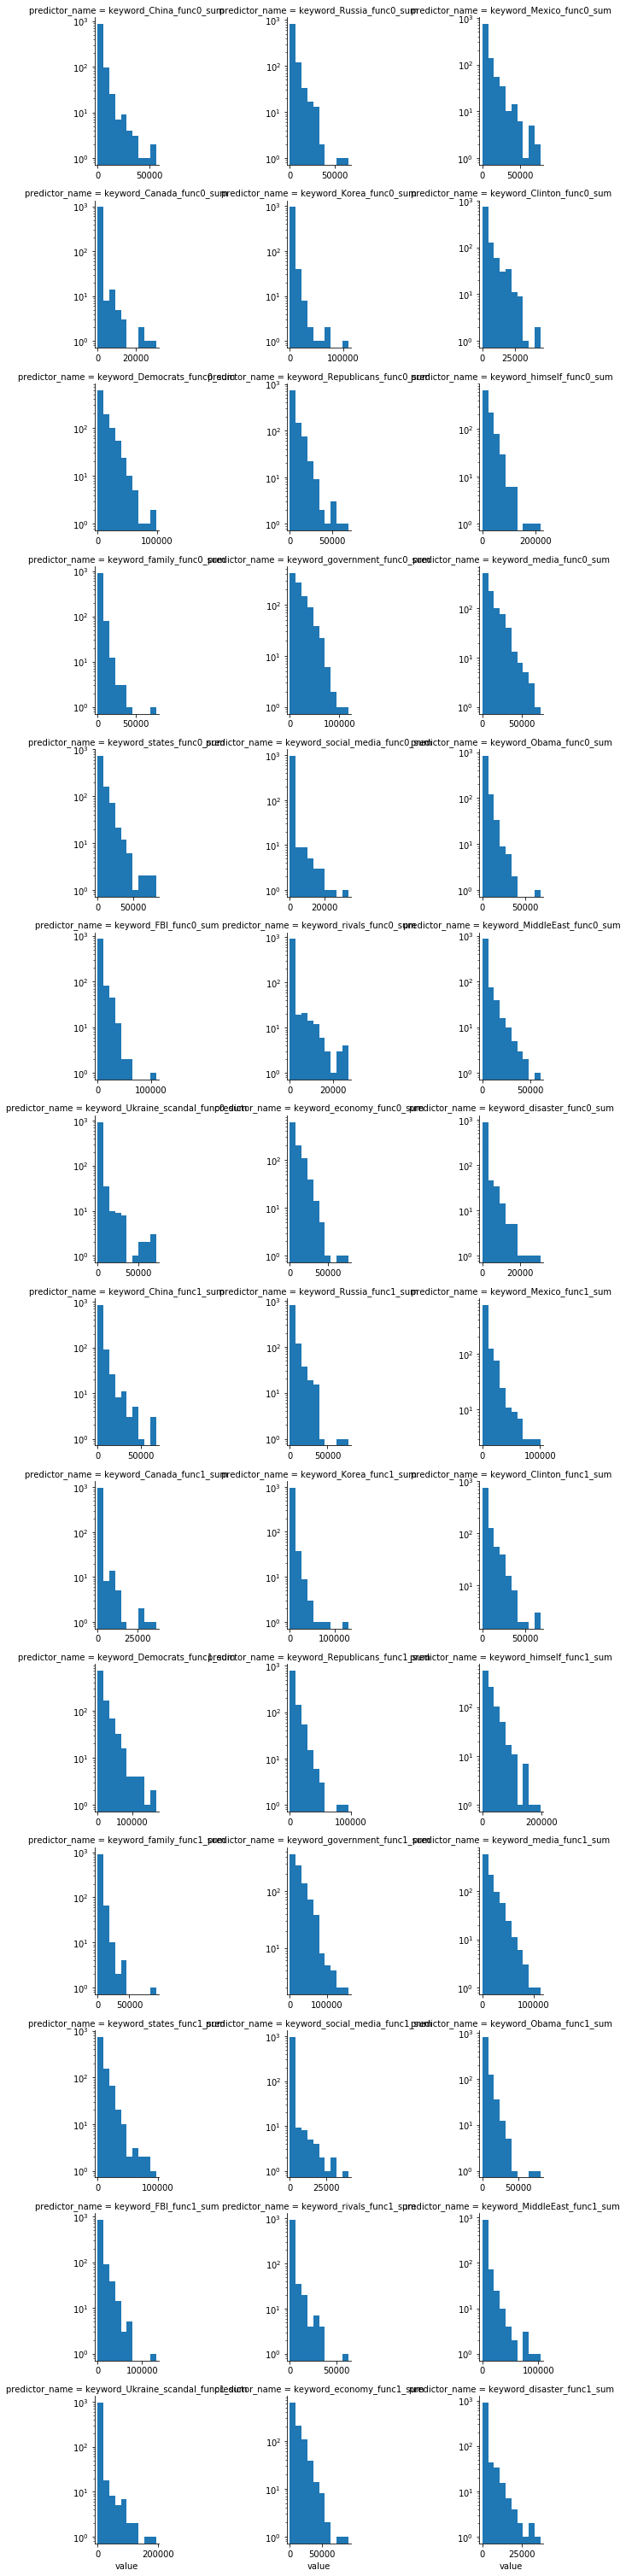

In [232]:
res_tidy = pd.melt(res, id_vars=['year_', 'month_', 'day_'], 
                    var_name='predictor_name', 
                    value_name='value')
res_tidy_sums = res_tidy[['sum' in n for n in res_tidy.predictor_name]]

g = sns.FacetGrid(res_tidy_sums, col='predictor_name', col_wrap=3, sharex=False, sharey=False)
g.map(plt.hist, "value", log=True)   
plt.subplots_adjust(wspace=2)



In [140]:
### TESTING ###
test_df = pd.DataFrame([['A', 'A', 'A', 'B', 'B', 'C', 'C', 'C'],
                        [0, 0, 1, 0, 0, 1, 1, 0],
                        [1, 0, 0, 1, 0, 0, 0, 0],
                        [0.3, 0.7, 0.4, 0.5, 0.2, 0.1, 0.2, 0.5],
                        [0.2, 0.1, 0.6, 0.2, 0.3, 0.8, 0.3, 0.1],
                        [50, 100, 20, 10, 3, 1000, 80, 55]],
                       index=['group', 'keyword_1', 'keyword_2', 'positive_sentiment_pd', 'negative_sentiment_pd', 'retweet_count']).T
print(test_df)

keywords = ['keyword_1', 'keyword_2']

group_tweets(test_df, 
             keywords, 
             lambda x: (x['positive_sentiment_pd'] - x['negative_sentiment_pd'])*(x['retweet_count']+1),
             ['group'], 
             ['min', 'max', 'sum'])
#print(test_df.apply(row_func['keyword_2'], axis=1))
#test_df.apply(lambda x: (x.positive_sentiment_pd - x.negative_sentiment_pd)*(x.retweet_count+1)*x['keyword_1'], axis=1)
#test_df.apply(lambda x: (x.positive_sentiment_pd - x.negative_sentiment_pd)*(x.retweet_count+1)*x['keyword_2'], axis=1)

  group keyword_1 keyword_2 positive_sentiment_pd negative_sentiment_pd  \
0     A         0         1                   0.3                   0.2   
1     A         0         0                   0.7                   0.1   
2     A         1         0                   0.4                   0.6   
3     B         0         1                   0.5                   0.2   
4     B         0         0                   0.2                   0.3   
5     C         1         0                   0.1                   0.8   
6     C         1         0                   0.2                   0.3   
7     C         0         0                   0.5                   0.1   

  retweet_count  
0            50  
1           100  
2            20  
3            10  
4             3  
5          1000  
6            80  
7            55  
  keyword_1 keyword_2
0         0       5.1
1         0         0
2      -4.2        -0
3         0       3.3
4        -0        -0
5    -700.7        -0
6      -

(array([[ 0.70072057,  0.        ,  0.70079387,  0.        ,  1.08908156,
          1.08908156],
        [ 0.71347383,  0.        ,  0.71340096, -0.        ,  0.23675686,
          0.23675686],
        [-1.41419439,  0.        , -1.41419483, -0.        , -1.32583843,
         -1.32583843]]),
 StandardScaler(copy=True, with_mean=True, with_std=True))

In [209]:
np.random.choice([-1, 1])

1